In [10]:
import torch
import pytorch3d
import pytorch3d.renderer as rdr
from pytorch3d.structures import Meshes
from pytorch3d.io import load_objs_as_meshes
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm.notebook import tqdm

In [11]:
def make_cube(device, edge_length):
    vertices = (edge_length)*torch.tensor([
        [-0.5, 0.5, -0.5],
        [0.5, 0.5, -0.5],
        [0.5, 0.5, 0.5],
        [-0.5, 0.5, 0.5],
        [0.5, -0.5, -0.5],
        [0.5, -0.5, 0.5],
        [-0.5, -0.5, 0.5],
        [-0.5, -0.5, -0.5]
     ], dtype=torch.float32, device=device)

    faces = torch.tensor([
        [0, 1, 3],
        [1, 2, 3],
        [1, 2, 5],
        [1, 4, 5],
        [4, 5, 7],
        [5, 6, 7],
        [3, 6, 7],
        [3, 0, 7],
        [2, 6, 3],
        [2, 5, 6],
        [0, 4, 7],
        [0, 1, 4]
     ], dtype=torch.int64, device=device)
    
    color = torch.tensor([0.0, 0.0, 1.0], device=device)
    vertex_colors = torch.ones_like(vertices)[None] * color
    textures = rdr.TexturesVertex(verts_features=vertex_colors)

    mesh = Meshes(
      verts=[vertices],
      faces=[faces],
      textures=textures
     )
    
    return mesh

In [12]:
def get_mesh_renderer(image_size=512):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    R, T = rdr.look_at_view_transform(2.7, 0, 0)
    cameras = rdr.FoVPerspectiveCameras(device=device, R=R, T=T)
    
    raster_set = rdr.RasterizationSettings(
        image_size=image_size, 
        blur_radius=0.0, 
        faces_per_pixel=1
    )
    
    lights = rdr.PointLights(device=device, location=[[0.0, 0.0, -3.0]])
    
    render = rdr.MeshRenderer(
        rasterizer=rdr.MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_set
        ),
        shader=rdr.HardPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights
        )
    )
    return render

In [13]:
def render_360_degree_mesh(mesh, device, image_size=512, num_views=72, distance=2.75, elevation=30):
    renderer = get_mesh_renderer(image_size=image_size)
    angles = torch.linspace(-180, 180, num_views)
    lights = rdr.PointLights(location=[[0, 0, -3]], device=device)
    images = []
    
    for angle in tqdm(angles):
        R, T = rdr.look_at_view_transform(dist=distance, elev=elevation, azim=angle)
        cameras = rdr.FoVPerspectiveCameras(R=R, T=T, device=device)
        
        render = renderer(mesh, cameras=cameras, lights=lights)
        image = render[0, ..., :3].cpu().numpy()
        image = (image * 255).astype(np.uint8)
        images.append(image)
    
    return images

In [14]:
def save_gif(images, output_path, fps=24):
    duration = 1000 // fps
    imageio.mimsave(
        output_path,
        images,
        duration=duration,
        loop=0
    )

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tetra_mesh = make_cube("cuda:0", 5)

rendered_images = render_360_degree_mesh(
    tetra_mesh,
    device=device,
    image_size=512,
    num_views=120,
    distance=9,  
    elevation=30
)

save_gif(rendered_images, 'cube_360.gif', fps=30)

  0%|          | 0/120 [00:00<?, ?it/s]

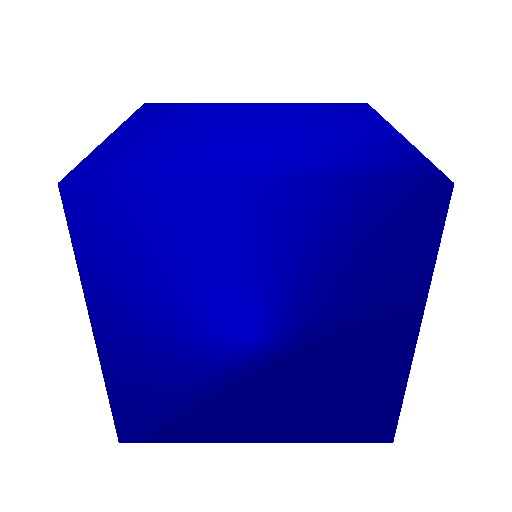

In [18]:
from IPython.display import Image
Image(filename='cube_360.gif')